# Step 1: Scrape competitor's data 

finding table with class then reading it using pandas and setting data frame columns

In [2]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np


#step:1

url = 'https://www.spaceweatherlive.com/en/solar-activity/top-50-solar-flares'
response = requests.get(url)
html_raw = response.text
html_soup = BeautifulSoup(html_raw, 'html.parser')
#print(html_soup.prettify())

Top_50_solar_flares_table = html_soup.find("table" , {"class": "table table-striped table-responsive-md"})
Top_50_solar_flares_df_list = pd.read_html(str(Top_50_solar_flares_table))


Top_50_solar_flares_df = Top_50_solar_flares_df_list[0]
Top_50_solar_flares_df.columns = ['Rank','X_Class','Date','Region','Start','Maximum','End','Movie']
print(Top_50_solar_flares_df.to_string(index=False))


 Rank X_Class        Date  Region  Start Maximum    End              Movie
    1    X28+  2003/11/04     486  19:29   19:53  20:06  MovieView archive
    2    X20+  2001/04/02    9393  21:32   21:51  22:03  MovieView archive
    3  X17.2+  2003/10/28     486  09:51   11:10  11:24  MovieView archive
    4    X17+  2005/09/07     808  17:17   17:40  18:03  MovieView archive
    5   X14.4  2001/04/15    9415  13:19   13:50  13:55  MovieView archive
    6     X10  2003/10/29     486  20:37   20:49  21:01  MovieView archive
    7    X9.4  1997/11/06    8100  11:49   11:55  12:01  MovieView archive
    8    X9.3  2017/09/06    2673  11:53   12:02  12:10  MovieView archive
    9      X9  2006/12/05     930  10:18   10:35  10:45  MovieView archive
   10    X8.3  2003/11/02     486  17:03   17:25  17:39  MovieView archive
   11    X8.2  2017/09/10    2673  15:35   16:06  16:31  MovieView archive
   12    X7.1  2005/01/20     720  06:36   07:01  07:26  MovieView archive
   13    X6.9  2011/08/09

# Step 2: Tidy the top 50 solar flare data

dropping the last column then iterating over data frame rows and combining date with time after casting cells into date and time objects, finally replacing the missing cells in region column with NaN

In [3]:
from datetime import datetime
Top_50_solar_flares_df = Top_50_solar_flares_df.drop(Top_50_solar_flares_df.columns[-1],axis=1)
for index, row in Top_50_solar_flares_df.iterrows():
    date = datetime.strptime(row['Date'], '%Y/%m/%d').date()
    start_time = datetime.strptime(row['Start'], '%H:%M').time()
    maximum_time = datetime.strptime(row['Maximum'], '%H:%M').time()
    end_time = datetime.strptime(row['End'], '%H:%M').time()
    Top_50_solar_flares_df.at[index,'Start'] = datetime.combine(date, start_time)
    Top_50_solar_flares_df.at[index,'Maximum'] = datetime.combine(date, maximum_time)
    Top_50_solar_flares_df.at[index,'End'] = datetime.combine(date, end_time)
Top_50_solar_flares_df = Top_50_solar_flares_df.drop('Date', 1)

#set values
Top_50_solar_flares_df['Region'] = Top_50_solar_flares_df['Region'].replace('-', np.nan)

print(Top_50_solar_flares_df.to_string(index=False))


 Rank X_Class  Region                Start              Maximum                  End
    1    X28+     486  2003-11-04 19:29:00  2003-11-04 19:53:00  2003-11-04 20:06:00
    2    X20+    9393  2001-04-02 21:32:00  2001-04-02 21:51:00  2001-04-02 22:03:00
    3  X17.2+     486  2003-10-28 09:51:00  2003-10-28 11:10:00  2003-10-28 11:24:00
    4    X17+     808  2005-09-07 17:17:00  2005-09-07 17:40:00  2005-09-07 18:03:00
    5   X14.4    9415  2001-04-15 13:19:00  2001-04-15 13:50:00  2001-04-15 13:55:00
    6     X10     486  2003-10-29 20:37:00  2003-10-29 20:49:00  2003-10-29 21:01:00
    7    X9.4    8100  1997-11-06 11:49:00  1997-11-06 11:55:00  1997-11-06 12:01:00
    8    X9.3    2673  2017-09-06 11:53:00  2017-09-06 12:02:00  2017-09-06 12:10:00
    9      X9     930  2006-12-05 10:18:00  2006-12-05 10:35:00  2006-12-05 10:45:00
   10    X8.3     486  2003-11-02 17:03:00  2003-11-02 17:25:00  2003-11-02 17:39:00
   11    X8.2    2673  2017-09-10 15:35:00  2017-09-10 16:06:00  

# Step 3: Scrape the NASA data

extracting the table text using 'pre' tag then setting data frame columns then loading the table text into data frame after splitting it with neglecting text above table then writing data frame into csv file

In [10]:
url_ = 'https://cdaw.gsfc.nasa.gov/CME_list/radio/waves_type2.html'
response_ = requests.get(url_)
html_raw_ = response_.text
html_soup_ = BeautifulSoup(html_raw_, 'html.parser')
NASA_table = html_soup_.find("pre")
NASA_table_df = pd.DataFrame(columns = ['Start_date','S_time','E_date','E_time','S_Freq.','E_Freq.','Location','Region',
                                       'Imp.', 'CME_d', 'CME_t', 'CPA', 'width' , 'sp.' , 'plots'])
for index, row in enumerate(NASA_table.text.splitlines()):
    row_data = row.split()
    if(index < 12 or len(row_data) < 15): 
        continue
    cur_index = len(NASA_table_df)
    NASA_table_df.loc[cur_index, :14] = row_data[:14]
    NASA_table_df.loc[cur_index, 'plots'] = ' '.join(row_data[14:])
    
    
NASA_table_df.to_csv('NASA.csv', encoding='utf-8', index=False)

tmp_df = pd.read_csv('NASA.csv')
print(tmp_df.to_string(index=False))


 Start_date S_time E_date E_time S_Freq. E_Freq. Location      Region   Imp.  CME_d  CME_t   CPA width   sp.                                          plots
 1997/04/01  14:00  04/01  14:15    8000    4000   S25E16        8026   M1.3  04/01  15:18    74    79   312                                           PHTX
 1997/04/07  14:30  04/07  17:30   11000    1000   S28E19        8027   C6.8  04/07  14:27  Halo   360   878                                           PHTX
 1997/05/12  05:15  05/14  16:00   12000      80   N21W08        8038   C1.3  05/12  05:30  Halo   360   464                                           PHTX
 1997/05/21  20:20  05/21  22:00    5000     500   N05W12        8040   M1.3  05/21  21:00   263   165   296                                           PHTX
 1997/09/23  21:53  09/23  22:16    6000    2000   S29E25        8088   C1.4  09/23  22:02   133   155   712                                           PHTX
 1997/11/03  05:15  11/03  12:00   14000     250   S20W13       

# Step 4: Tidy the NASA table

replacing all missing entries as NaN and adding is_halo and width lower_bound column then iterating over data frame to combining date with time and checking the two boolean columns to filling it

In [5]:
import math
from datetime import datetime, date, time, timedelta
NASA_table_df['S_Freq.'] = NASA_table_df['S_Freq.'].replace('????', np.nan)
NASA_table_df['E_Freq.'] = NASA_table_df['E_Freq.'].replace('????', np.nan)
NASA_table_df['Location'] = NASA_table_df['Location'].replace('------', np.nan)
NASA_table_df['Region'] = NASA_table_df['Region'].replace('-----', np.nan)
NASA_table_df['Imp.'] = NASA_table_df['Imp.'].replace('----', np.nan)
NASA_table_df['CME_d'] = NASA_table_df['CME_d'].replace('--/--', np.nan)
NASA_table_df['CME_t'] = NASA_table_df['CME_t'].replace('--:--', np.nan)
NASA_table_df['CPA'] = NASA_table_df['CPA'].replace('----', np.nan)
NASA_table_df['width'] = NASA_table_df['width'].replace('---', np.nan)
NASA_table_df['sp.'] = NASA_table_df['sp.'].replace('----', np.nan)

NASA_table_df['is_halo'] = np.nan
NASA_table_df['width_lower_bound'] = np.nan


for index, row in NASA_table_df.iterrows():
    if(row['CPA'] == 'Halo'):
        NASA_table_df.loc[index, 'CPA'] = 'NA'
        NASA_table_df.loc[index, 'is_halo'] = True
    else:
        NASA_table_df.loc[index, 'is_halo'] = False
    try:
        if (row['width'][0] == '>'):
            NASA_table_df.loc[index, 'width_lower_bound'] = True
        else:
            NASA_table_df.loc[index, 'width_lower_bound'] = False
    except Exception as e:
        NASA_table_df.loc[index, 'width_lower_bound'] = False
    
    date = datetime.strptime(row['Start_date'], '%Y/%m/%d').date()
    time = datetime.strptime(row['S_time'], '%H:%M').time()
    NASA_table_df.at[index,'Start_date'] = datetime.combine(date, end_time)
    
    date = datetime.strptime(row['E_date'], '%m/%d').date()
    if(row['E_time'] == '24:00'):
        time = datetime.strptime('00:00', '%H:%M').time()
        NASA_table_df.at[index,'E_date'] = datetime.combine(date + timedelta(days=1), end_time)
    else:
        time = datetime.strptime(row['E_time'], '%H:%M').time()
        NASA_table_df.at[index,'E_date'] = datetime.combine(date, end_time)
        
    try:
        date = datetime.strptime(row['CME_d'], '%m/%d').date()
        if(row['CME_t'] == '24:00'):
            time = datetime.strptime('00:00', '%H:%M').time()
            NASA_table_df.at[index,'CME_d'] = datetime.combine(date + timedelta(days=1), end_time)
        else:
            time = datetime.strptime(row['CME_t'], '%H:%M').time()
            NASA_table_df.at[index,'CME_d'] = datetime.combine(date, end_time)
    except Exception as e:
        pass




NASA_table_df = NASA_table_df.drop('S_time', 1)
NASA_table_df = NASA_table_df.drop('E_time', 1)
NASA_table_df = NASA_table_df.drop('CME_t', 1)

print(NASA_table_df.to_string(index=False))

          Start_date               E_date S_Freq. E_Freq. Location      Region   Imp.                CME_d  CPA width   sp.                                          plots is_halo width_lower_bound
 1997-04-01 11:09:00  1900-04-01 11:09:00    8000    4000   S25E16        8026   M1.3  1900-04-01 11:09:00   74    79   312                                           PHTX   False             False
 1997-04-07 11:09:00  1900-04-07 11:09:00   11000    1000   S28E19        8027   C6.8  1900-04-07 11:09:00   NA   360   878                                           PHTX    True             False
 1997-05-12 11:09:00  1900-05-14 11:09:00   12000      80   N21W08        8038   C1.3  1900-05-12 11:09:00   NA   360   464                                           PHTX    True             False
 1997-05-21 11:09:00  1900-05-21 11:09:00    5000     500   N05W12        8040   M1.3  1900-05-21 11:09:00  263   165   296                                           PHTX   False             False
 1997-09-23 11:

# Question 1: Replication 

sorting based on Imp. column 
each row mapped into 3 values(importance letter, importance number, index in data frame) to sort rows correctly
then filling a new data frame using third element in a list(index in data frame)


In [6]:
NASA_50_df = NASA_table_df[0:0]
Class = []
for index, row in NASA_table_df.iterrows():
    try:
        Class.append([row['Imp.'][0],float(row['Imp.'][1:]), index])
    except Exception as e:
        pass
Class.sort(reverse = True)
for i in range(50):
    NASA_50_df.loc[i] = NASA_table_df.loc[Class[i][2], :]

print(NASA_50_df.to_string(index=False))


         Start_date              E_date S_Freq. E_Freq. Location Region  Imp.               CME_d  CPA width   sp.                                      plots is_halo width_lower_bound
2003-11-04 11:09:00 1900-11-05 11:09:00   10000     200   S19W83  10486  X28. 1900-11-04 11:09:00   NA   360  2657                                       PHTX    True             False
2001-04-02 11:09:00 1900-04-03 11:09:00   14000     250   N19W72   9393  X20. 1900-04-02 11:09:00  261   244  2505                                       PHTX   False             False
2003-10-28 11:09:00 1900-10-30 11:09:00   14000      40   S16E08  10486  X17. 1900-10-28 11:09:00   NA   360  2459                                       PHTX    True             False
2001-04-15 11:09:00 1900-04-16 11:09:00   14000      40   S20W85   9415  X14. 1900-04-15 11:09:00  245   167  1199                                       PHTX   False             False
2003-10-29 11:09:00 1900-10-30 11:09:00   11000     500   S15W02  10486  X10. 19

C:\Users\HaNSeL\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


# Question 2: Integration 

comparing each row in NASA data with each row in SpaceWeatherLive data using Start_Date and Region and Importance Attributes

In [7]:
NASA_table_df['rank'] = np.nan

for space_index, space_row in Top_50_solar_flares_df.iterrows():
    for NASA_index, NASA_row in NASA_table_df.iterrows():
        
        if(space_row['Start'].date() != NASA_row['Start_date'].date()):continue
            
        try:
            if(str(space_row['Region']) not in NASA_row['Region']):continue
        except Exception as e:
            pass
        try:
            space_importance = space_row['X_Class'][0]
            NASA_importance = NASA_row['Imp.'][0]

            if(space_importance != NASA_importance):continue

            space_importance = space_row['X_Class'][1:]
            NASA_importance = NASA_row['Imp.'][1:]
            if(space_importance[len(space_importance) -1] == '+'):space_importance = space_importance[:-1]
            if(float(space_importance) != float(NASA_importance)):continue
        except Exception as E:
            pass
        NASA_table_df.at[NASA_index,'rank'] = space_row['Rank']

print(NASA_table_df.to_string(index=False))


          Start_date               E_date S_Freq. E_Freq. Location      Region   Imp.                CME_d  CPA width   sp.                                          plots is_halo width_lower_bound  rank
 1997-04-01 11:09:00  1900-04-01 11:09:00    8000    4000   S25E16        8026   M1.3  1900-04-01 11:09:00   74    79   312                                           PHTX   False             False   NaN
 1997-04-07 11:09:00  1900-04-07 11:09:00   11000    1000   S28E19        8027   C6.8  1900-04-07 11:09:00   NA   360   878                                           PHTX    True             False   NaN
 1997-05-12 11:09:00  1900-05-14 11:09:00   12000      80   N21W08        8038   C1.3  1900-05-12 11:09:00   NA   360   464                                           PHTX    True             False   NaN
 1997-05-21 11:09:00  1900-05-21 11:09:00    5000     500   N05W12        8040   M1.3  1900-05-21 11:09:00  263   165   296                                           PHTX   False          

# Question 3: Analysis

-first pie chart shows the percentage of flares in the top 50 that have Halo
-second pie chart shows the percentage of flares in whole dataset that have Halo

-the flares in the top 50 tend to have Halo CMEs 

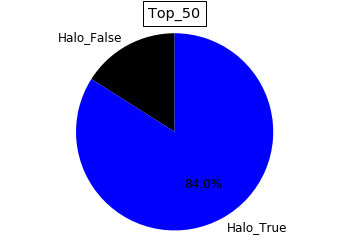

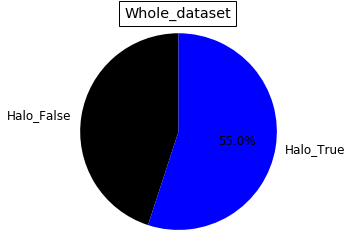

In [8]:
import matplotlib.pyplot as plt

is_halo_NASA_50_df = NASA_50_df.loc[NASA_50_df['is_halo'] == True]
is_halo_NASA_table_df = NASA_table_df.loc[NASA_table_df['is_halo'] == True]


is_halo_top_50_true = len(is_halo_NASA_50_df)
is_halo_top_50_false  = len(NASA_50_df) - len(is_halo_NASA_50_df)

plt.rcParams.update({'font.size': 12}) 

plt.pie([is_halo_top_50_false, is_halo_top_50_true],
        colors=["black","blue"],
        labels=["Halo_False", "Halo_True"],
        autopct='%1.1f%%', 
        startangle=90)
plt.title('Top_50', bbox={'facecolor':'1.0', 'pad':5})

plt.axis('equal') 
plt.show()

is_halo_Whole_true = len(is_halo_NASA_table_df)
is_halo_Whole_false  = len(NASA_table_df) - len(is_halo_NASA_table_df)

plt.pie([is_halo_Whole_false, is_halo_Whole_true],
        colors=["black","blue"],
        labels=["Halo_False", "Halo_True"],
        autopct='%1.1f%%', 
        startangle=90)
plt.title('Whole_dataset', bbox={'facecolor':'1', 'pad':5})

plt.axis('equal') 
plt.show()
